In [8]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'

In [9]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEARM.hex
rm -f -- simpleserial-aes-CWLITEARM.eep
rm -f -- simpleserial-aes-CWLITEARM.cof
rm -f -- simpleserial-aes-CWLITEARM.elf
rm -f -- simpleserial-aes-CWLITEARM.map
rm -f -- simpleserial-aes-CWLITEARM.sym
rm -f -- simpleserial-aes-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i aes.i aes-independant.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (GNU Arm Embedded Toolchain 9-2020-q2-update) 9.3.1 20200408 (release)
Copyright (C) 2019 Free Software 

In [10]:
%run "../Setup_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [3]:
fw_path = "../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 7223 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 7223 bytes
Serial baud rate = 38400


In [11]:
if PLATFORM == "CWLITEXMEGA":
    def reboot_flush():            
        scope.io.pdic = False
        time.sleep(0.1)
        scope.io.pdic = "high_z"
        time.sleep(0.1)
        #Flush garbage too
        target.flush()
else:
    def reboot_flush():            
        scope.io.nrst = False
        time.sleep(0.05)
        scope.io.nrst = "high_z"
        time.sleep(0.05)
        #Flush garbage too
        target.flush()

In [12]:
scope.clock.adc_src = "clkgen_x1"
reboot_flush()
scope.arm()
target.simpleserial_write('p', bytearray([0]*16))
ret = scope.capture()
if ret:
    print("No trigger!")

wave = scope.get_last_trace()

output = target.simpleserial_read_witherrors('r', 16)
gold_ct = output['payload']

In [13]:
print(gold_ct)

CWbytearray(b'7d f7 6b 0c 1a b8 99 b3 3e 42 f0 47 b9 1b 54 6f')


<IPython.core.display.Javascript object>


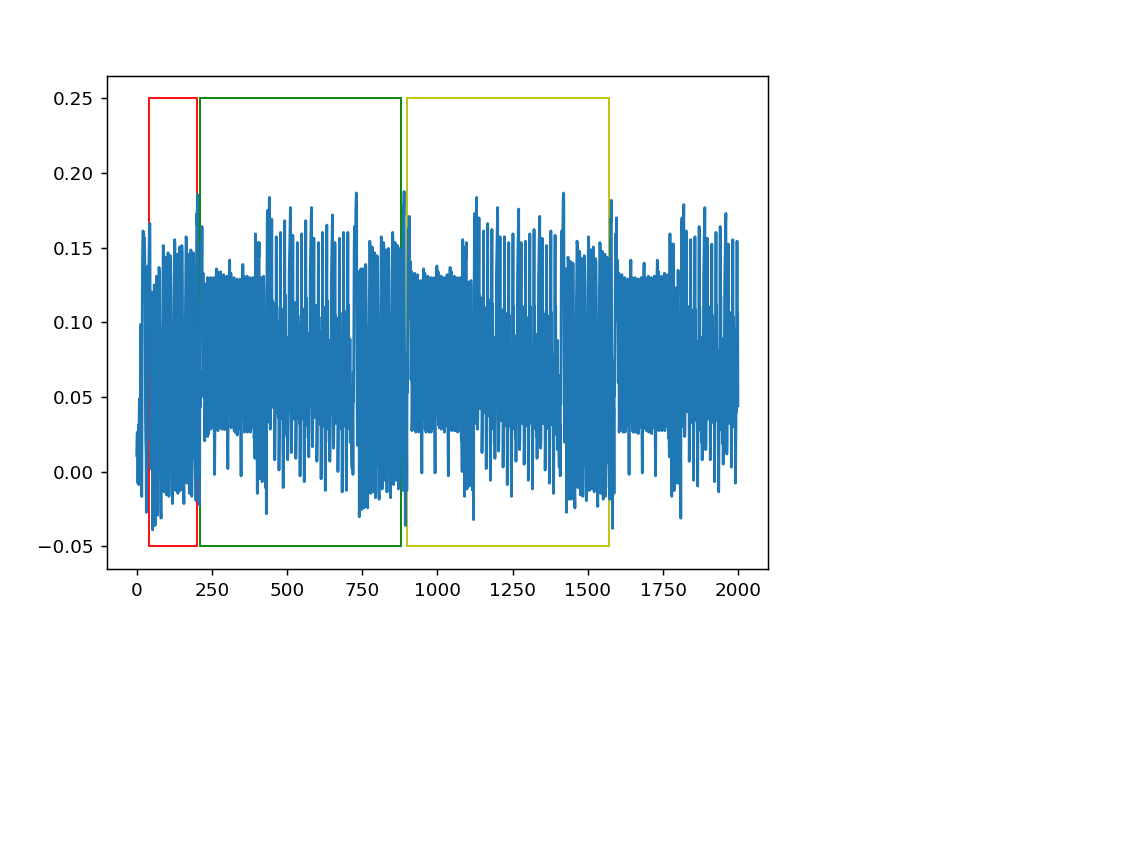

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.figure()
AddRoundKey0 = Rectangle((40, -0.05), 160, 0.3, fill=False, color='r')
Round1 = Rectangle((210, -0.05), 670, 0.3, fill=False, color='g')
Round2 = Rectangle((900, -0.05), 670, 0.3, fill=False, color='y')
plt.plot(wave[:2000])
plt.gca().add_patch(AddRoundKey0)
plt.gca().add_patch(Round1)
plt.gca().add_patch(Round2)
plt.show()

In [18]:
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])
gc.display_stats()
gc.set_range("width", 2, 15)
gc.set_range("offset", -14, -12)
gc.set_global_step(1)

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

In [19]:
scope.glitch.clk_src = "clkgen"
scope.glitch.output = "clock_xor"
scope.glitch.trigger_src = "ext_single"
scope.glitch.repeat = 1
scope.io.hs2 = "glitch"
scope.glitch.width = 3
scope.glitch.offset = -12.8
print(scope.glitch)

clk_src     = clkgen
width       = 3.125
width_fine  = 0
offset      = -12.890625
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 899
repeat      = 1
output      = clock_xor



In [56]:
from tqdm.notebook import tqdm, trange
wave = None
import logging
ktp = cw.ktp.Basic()
logging.getLogger().setLevel(logging.ERROR)
reboot_flush()
for i in trange(870, 900):
    scope.adc.timeout = 0.2
    scope.glitch.ext_offset = i
    ack = None
    while ack is None:
        target.simpleserial_write('k', ktp.next()[0])
        ack = target.simpleserial_wait_ack()
        if ack is None:
            reboot_flush()
            time.sleep(0.1)
    
    scope.arm()
    
    pt = bytearray([0]*16)
    target.simpleserial_write('p', pt)
    ret = scope.capture()
    if ret:
        reboot_flush() #bad if we accidentally didn't have this work
        time.sleep(0.1)
        print("timed out!")
        continue
    output = target.simpleserial_read_witherrors('r', 16, glitch_timeout = 1)
    if output['valid']:
        if output['payload'] != gold_ct:
            print("Glitched at {}".format(i))
            wave = scope.get_last_trace()
            break
    else:
        reboot_flush()

Glitched at 881



<IPython.core.display.Javascript object>


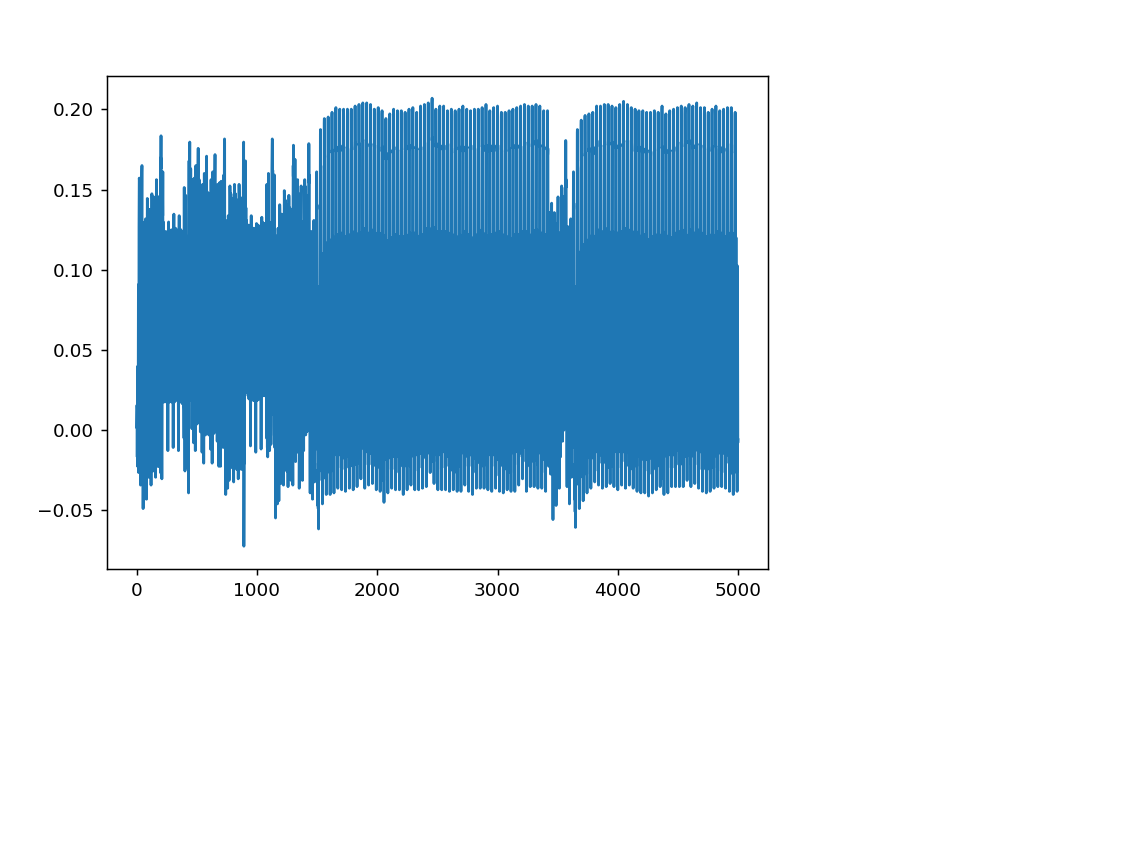

In [57]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(wave)
plt.show()

In [58]:
print(output)

{'valid': True, 'payload': CWbytearray(b'74 12 e3 94 6e ea 83 eb 99 55 52 09 28 38 5a 8d'), 'full_response': 'r7412E3946EEA83EB9955520928385A8D\n', 'rv': 0}


In [59]:
ct1 = output['payload']

In [60]:
from tqdm.notebook import tqdm, trange
wave = None
import logging
ktp = cw.ktp.Basic()
logging.getLogger().setLevel(logging.ERROR)
reboot_flush()
while True:
    scope.adc.timeout = 0.2
    scope.glitch.ext_offset = i
    ack = None
    while ack is None:
        target.simpleserial_write('k', ktp.next()[0])
        ack = target.simpleserial_wait_ack()
        if ack is None:
            reboot_flush()
    
    scope.arm()
    
    pt = bytearray([0]*16)
    target.simpleserial_write('p', pt)
    ret = scope.capture()
    if ret:
        reboot_flush() #bad if we accidentally didn't have this work
        time.sleep(0.1)
        print("timed out!")
        continue
    output = target.simpleserial_read_witherrors('r', 16, glitch_timeout = 1)
    if output['valid']:
        if output['payload'] != gold_ct:
            print("Glitched at {}".format(i))
            print(output)
            wave = scope.get_last_trace()
            break
    else:
        reboot_flush()

Glitched at 881
{'valid': True, 'payload': CWbytearray(b'ad ae 63 70 3c d2 e8 0e 6b 97 c7 fb 52 ae e3 ce'), 'full_response': 'rADAE63703CD2E80E6B97C7FB52AEE3CE\n', 'rv': 0}


In [61]:
ct2 = output['payload']

In [65]:
Known = [0] * 49
Known[0] = 1

for i in range(4):
    for j in range(4):
        Known[48-(i*4+j)] = ct2[i+j*4]
        Known[16-(i*4+j)] = ct1[i+j*4]

In [63]:
print(Known)

[1, 206, 251, 14, 112, 227, 199, 232, 99, 174, 151, 210, 174, 82, 107, 60, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 141, 9, 235, 148, 90, 82, 131, 227, 56, 85, 234, 18, 40, 153, 110, 116]


In [66]:
from out2 import MakeTableMul2_8, Attack
#Known = [1, 141, 9, 235, 148, 90, 82, 131, 227, 56, 85, 234, 18, 40, 153, 110, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 206, 251, 14, 112, 227, 199, 232, 99, 174, 151, 210, 174, 82, 107, 60, 173]

MakeTableMul2_8()
kguess = Attack(Known)

# Solution found :

[[ 43  40 171   9]
 [126 174 247 207]
 [ 21 210  21  79]
 [ 22 166 136  60]]
[[160 136  35  42]
 [250  84 163 108]
 [254  44  57 118]
 [ 23 177  57   5]]


In [69]:
for i in range(4):
    print([hex(kguess[i][j]) for j in range(4)])

['0x2b', '0x28', '0xab', '0x9']
['0x7e', '0xae', '0xf7', '0xcf']
['0x15', '0xd2', '0x15', '0x4f']
['0x16', '0xa6', '0x88', '0x3c']


In [209]:
from tqdm.notebook import tqdm, trange
import numpy as np
scope.adc.timeout = 0.1
collected_pts = []
collected_cts = []
import logging
logging.getLogger().setLevel(logging.ERROR)
scope.glitch.output ="clock_xor"
scope.glitch.ext_offset = loc
for i in trange(256):
    scope.adc.timeout = 0.2
    reboot_flush() #bad if we accidentally didn't have this work
    ack = None
    while ack is None:
        target.simpleserial_write('k', ktp.next()[0]) #whoops
        ack = target.simpleserial_wait_ack()
    scope.glitch.trigger_src = "manual"
    
    target.flush()
    scope.arm()
    
    pt = bytearray([i]*16)
    target.simpleserial_write('p', pt)
    ret = scope.capture()
    while ret:
        reboot_flush() #bad if we accidentally didn't have this work
        #print("timed out!")
        #try again
        while ack is None:
            target.simpleserial_write('k', ktp.next()[0]) #whoops
            ack = target.simpleserial_wait_ack()
        target.flush()
        scope.arm()

        pt = bytearray([i]*16)
        target.simpleserial_write('p', pt)
        ret = scope.capture()

    good_ct = target.simpleserial_read('r', 16)
    sad = np.sum(abs(ref - scope.get_last_trace()))
    if sad < 50:
        print("What")
        collected_cts.append(good_ct)
        continue
    
    #got a good ct, now can try glitching
    good = 0
    #ref = None
    #print(good_ct)
    
    #check twice
    target.flush()
    while not good:
        potential_ct = None
        for glitch_setting in gc.glitch_values():
            scope.adc.timeout = 0.2
            target.simpleserial_write('k', ktp.next()[0]) #whoops
            
            if target.simpleserial_wait_ack() is None:
                reboot_flush()
                continue
            
            scope.glitch.offset = glitch_setting[1]
            scope.glitch.width = glitch_setting[0]
            scope.glitch.trigger_src = "ext_single"
            target.flush()
            #scope.glitch.ext_offset = loc
            target.flush()
            scope.arm()
            target.simpleserial_write('p', pt)
            ret = scope.capture()
            if ret:
                #print("No trigger!")
                gc.add("reset", (scope.glitch.width, scope.glitch.offset))
                reboot_flush()
                print("no trigger")
                continue

            wave = scope.get_last_trace()

            output = target.simpleserial_read_witherrors('r', 16, timeout=50, glitch_timeout=1)
            target.flush()
            if output['valid']:
                if output['payload'] != good_ct:
                    sad = np.sum(abs(ref - scope.get_last_trace()))
                    if sad < 50:
                        real = bytearray(generate_glitch(pt, cipher))
                        good = True
                        collected_cts.append(real)
                        continue
                        if potential_ct is None:
                            potential_ct = output['payload']
                            continue
                        else:
                            if potential_ct == output['payload']:
                                good = True
                                collected_cts.append(potential_ct)
                                gc.add("success", (scope.glitch.width, scope.glitch.offset))
                                print(output['payload'])
                                break
                            else:
                                print(potential_ct, output['payload'])
                                potential_ct = output['payload']
                                continue
                else:
                    gc.add("normal", (scope.glitch.width, scope.glitch.offset))
            else:
                gc.add("reset", (scope.glitch.width, scope.glitch.offset))
                #print("no output")
                #print(output)
                reboot_flush()

WHAT
12.890625 -12.109375



KeyboardInterrupt: 

In [210]:
print(scope.glitch)

clk_src     = clkgen
width       = 12.890625
width_fine  = 0
offset      = -12.109375
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 881
repeat      = 1
output      = clock_xor



In [211]:
print(bytearray(generate_glitch(pt, cipher)))
print(output['payload'])
print(pt)

CWbytearray(b'37 c7 4e 15 2e ab f8 c0 7c 81 1b fe 85 7b 92 37')
CWbytearray(b'ee 7b ce f1 7c 93 93 25 8e 43 8e 0c ff ed 2b 74')
CWbytearray(b'07 07 07 07 07 07 07 07 07 07 07 07 07 07 07 07')


In [ ]:
3.90625 -12.890625
5.078125 -12.890625
12.890625 -10.9375
12.890625 -12.109375

In [171]:
print(collected_cts[:2])

[CWbytearray(b'74 12 e3 94 6e ea 83 eb 99 55 52 09 28 38 5a 8d'), CWbytearray(b'3e 7d cc 7f c0 25 15 6b 50 1d e9 1c fd c7 fd bf')]


In [172]:
guessed_key = []
from chipwhisperer.common.utils.aes_cipher import AESCipher, aes_tables
def decrypt_last_round(ct, key_guess):
    state = ct ^ key_guess
    state = aes_tables.i_sbox[state]
    return state

for kbyte in range(16):
    probable_guesses = []
    for key_guess in range(256):
        c = 0
        for ct in collected_cts:
            c ^= decrypt_last_round(ct[kbyte], key_guess)
        if c == 0:
            probable_guesses.append(key_guess)
    guessed_key.append(probable_guesses)

In [174]:
print(guessed_key)

[[], [29, 172], [], [97], [], [], [], [9, 96, 164], [209], [97], [], [212], [175, 217], [28, 83, 151, 190], [], []]


In [178]:
# get an AES cipher
import chipwhisperer as cw
from chipwhisperer.common.utils.aes_cipher import AESCipher, aes_tables
import chipwhisperer.analyzer as cwa
ktp = cw.ktp.Basic()
key = list(ktp.next()[0])
for i in range(10):
    key.extend(cwa.aes_funcs.key_schedule_rounds(key[0:16], 0, i+1))
    
cipher = AESCipher(key)
print(bytearray(key))

import random

def generate_glitch(pt, cipher):
    # Do AES, but stop before the last Mix Columns
    state = list(pt)
    state = state+[16-len(state)]*(16-len(state))
    cipher._add_round_key(state, 0)
    
    # we break out after one round
    cipher._sub_bytes(state)
    cipher._shift_rows(state)
    cipher._mix_columns(state, False)
    cipher._add_round_key(state, 1)
    
    
    #last round
    cipher._sub_bytes(state)
    cipher._shift_rows(state)
    cipher._add_round_key(state, 2)
    return state

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c a0 fa fe 17 88 54 2c b1 23 a3 39 39 2a 6c 76 05 f2 c2 95 f2 7a 96 b9 43 59 35 80 7a 73 59 f6 7f 3d 80 47 7d 47 16 fe 3e 1e 23 7e 44 6d 7a 88 3b ef 44 a5 41 a8 52 5b 7f b6 71 25 3b db 0b ad 00 d4 d1 c6 f8 7c 83 9d 87 ca f2 b8 bc 11 f9 15 bc 6d 88 a3 7a 11 0b 3e fd db f9 86 41 ca 00 93 fd 4e 54 f7 0e 5f 5f c9 f3 84 a6 4f b2 4e a6 dc 4f ea d2 73 21 b5 8d ba d2 31 2b f5 60 7f 8d 29 2f ac 77 66 f3 19 fa dc 21 28 d1 29 41 57 5c 00 6e d0 14 f9 a8 c9 ee 25 89 e1 3f 0c c8 b6 63 0c a6')


In [182]:
cts = []
n_wrong = 0
for i in range(256):
    e = [i]*16
    #e.extend([4]*15)
    ct = generate_glitch(e, cipher)
    if bytearray(ct) != collected_cts[i]:
        print("ct: {}\n    {}".format(bytearray(ct), collected_cts[i]))
        n_wrong+=1
        
print(n_wrong)

ct: CWbytearray(b'68 0f 02 9a 9d 2a 8c 5a bb 92 f2 5c 41 ba d7 33')
    CWbytearray(b'b1 b3 82 7e cf 12 e7 bf 49 50 67 ae 3b 2c 6e 70')
ct: CWbytearray(b'88 4e 65 cb 99 d3 fd ed d8 23 29 48 80 a4 70 3c')
    CWbytearray(b'51 f2 e5 2f cb eb 96 08 2a e1 bc ba fa 32 c9 7f')
ct: CWbytearray(b'fd c1 9a b3 23 f4 1b 4a 00 b7 8f 11 f5 c9 be df')
    CWbytearray(b'24 7d 1a 57 71 cc 70 af f2 75 1a e3 8f 5f 07 9c')
ct: CWbytearray(b'6c fb f8 6d 36 43 2f 52 82 9e 33 73 2d f9 17 cb')
    CWbytearray(b'b5 47 78 89 64 7b 44 b7 70 5c a6 81 57 6f ae 88')
ct: CWbytearray(b'6a 65 81 5f c0 2a 0e 1c 26 08 a5 6b bd 51 d9 1f')
    CWbytearray(b'b3 d9 01 bb 92 12 65 f9 d4 ca 30 99 c7 c7 60 5c')
ct: CWbytearray(b'28 58 58 b0 7d 12 6f 62 26 19 45 e3 80 54 0c 7f')
    CWbytearray(b'f1 e4 d8 54 2f 2a 04 87 d4 db d0 11 fa c2 b5 3c')
ct: CWbytearray(b'54 e1 25 9a f8 0e 0c f9 a3 1a ec db 00 df 7b 0c')
    CWbytearray(b'8d 5d a5 7e aa 36 67 1c 51 d8 79 29 7a 49 c2 4f')
ct: CWbytearray(b'b7 05 96 64 54 df 61 74 ee 91 

In [343]:
# get an AES cipher
import chipwhisperer as cw
from chipwhisperer.common.utils.aes_cipher import AESCipher, aes_tables

In [ ]:
print(probable_guesses)

In [323]:
scope.glitch

clk_src     = clkgen
width       = 1.953125
width_fine  = 0
offset      = -12.890625
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 886
repeat      = 1
output      = clock_only

In [257]:
def get_sad_plot(ref_trace, target_trace):
    ref_len = len(ref_trace)
    sads = []
    for i in range(0, len(target_trace) - ref_len):
        sads.append(np.sum(abs(ref_trace-target_trace[i:i+ref_len])))
    return sads

def calculate_trace_offset(ref_trace, orig_offset, target_trace, threshold):
    ref_len = len(ref_trace)
    for i in range(0, len(target_trace) - ref_len):
        if np.sum(abs(ref_trace-target_trace[i:i+ref_len])) < threshold:
            return i - orig_offset

In [258]:
def resync_with_SAD(ref, orig_offset, target_trace, threshold):
    target_offset = calculate_trace_offset(ref, orig_offset, target_trace, threshold)
    if target_offset > 0:
        new_trace = np.zeros(len(target_trace))
        new_trace[:-target_offset] = target_trace[target_offset:]
        return new_trace
    elif target_offset < 0:
        new_trace = np.zeros(len(target_trace))
        new_trace[-target_offset:] = target_trace[:target_offset]
        return new_trace
    return target_trace

In [259]:
ref_trace = ref[2000:2500]

In [260]:
new_trace = resync_with_SAD(ref_trace, 2000, wave, 10)

<IPython.core.display.Javascript object>


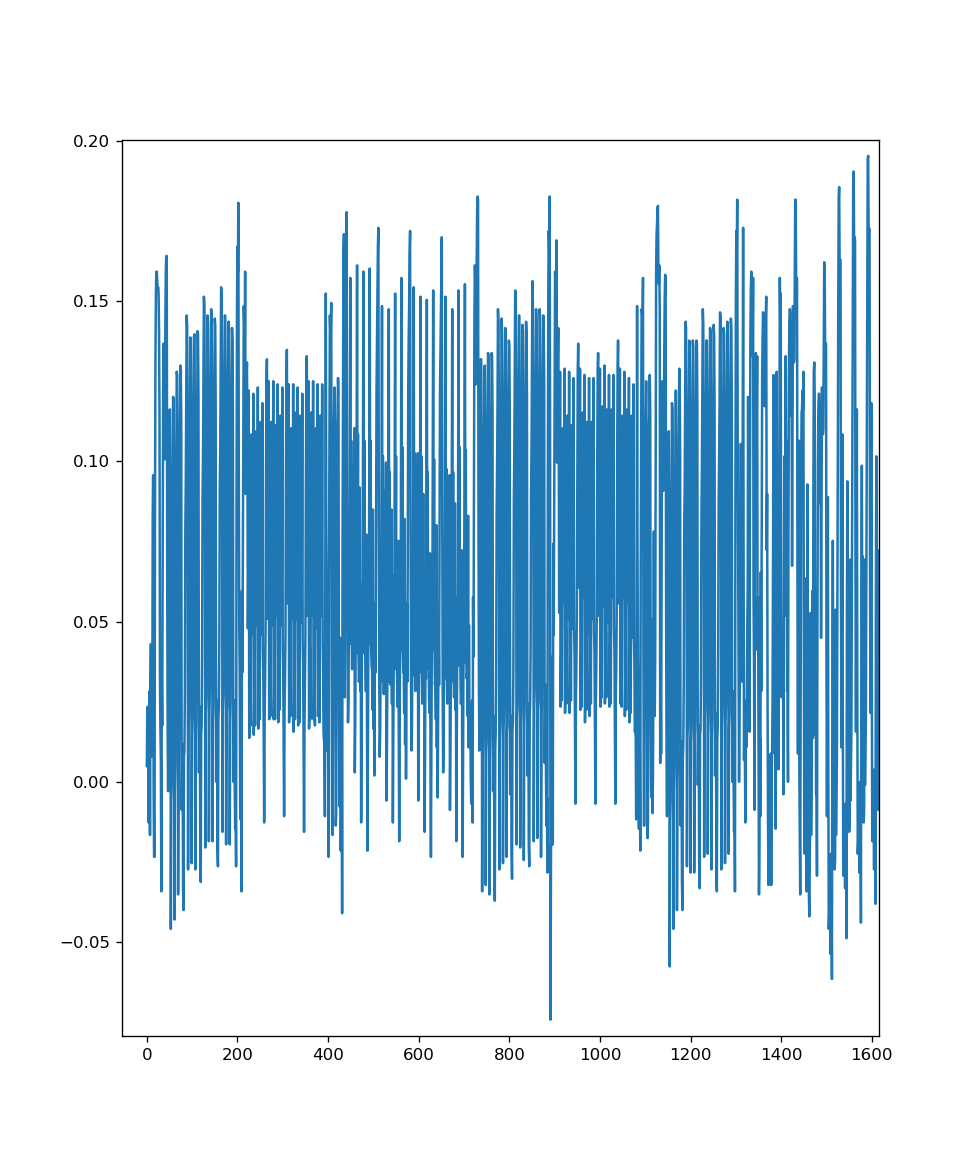

In [212]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(wave)
plt.show()

In [262]:
np.sum(abs(new_trace - ref))

142.390625

<IPython.core.display.Javascript object>


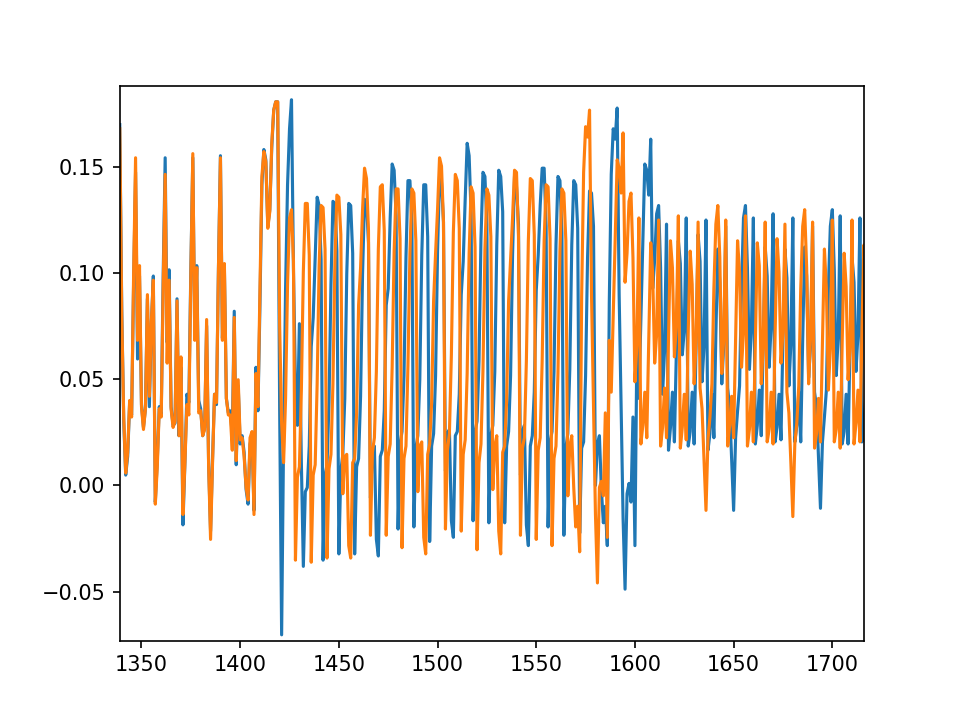

In [252]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(new_trace)
plt.plot(ref)
plt.show()

<IPython.core.display.Javascript object>


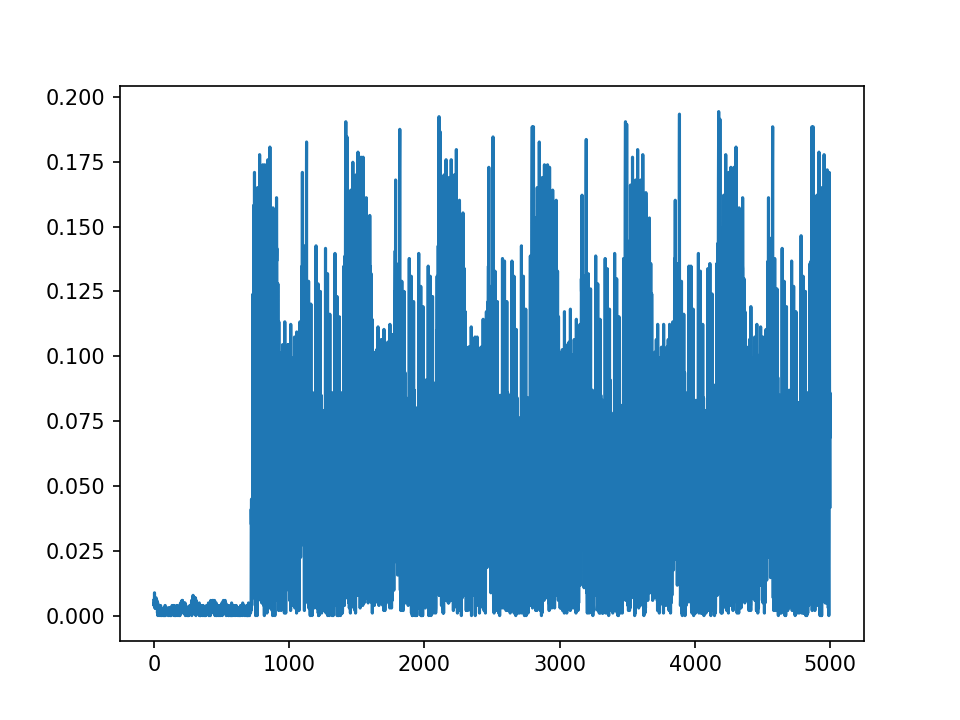

In [244]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(abs(wave - ref))
plt.show()

In [226]:
print(scope.adc.state)

True


<IPython.core.display.Javascript object>


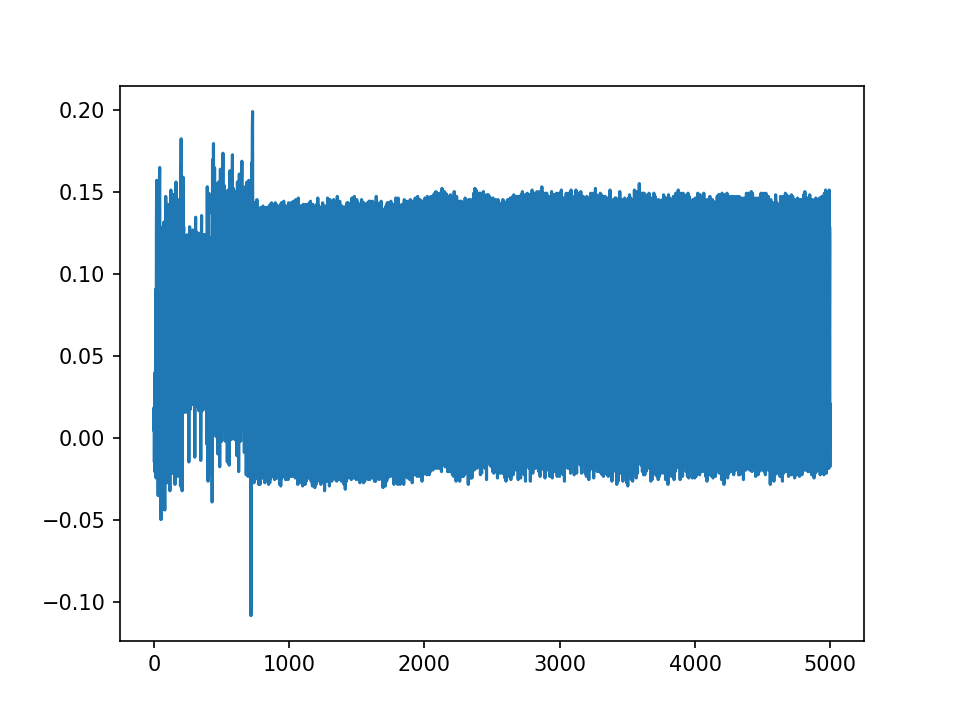

In [240]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(wave)
plt.show()

In [235]:
ref = wave

In [141]:
print(wave)

<bound method OpenADC.get_last_trace of cwlite Device
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state      = False
    basic_mode = rising_edge
    timeout    = 0.1
    offset     = 0
    presamples = 0
    samples    = 5000
    decimate   = 1
    trig_count = 6826
clock = 
    adc_src       = clkgen_x1
    adc_phase     = 0
    adc_freq      = 7384620
    adc_rate      = 7384620.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1       = serial_rx
    tio2       = serial_tx
    tio3       = high_z
    tio4       = high_z
    pdid       = high_z
    pdic       = high_z
    nrst       = high_z
    glitch_hp  = False
    glitch_lp  = False
    extclk_src = hs1
    hs2        = glitch
    target_pwr = True
   